In [ ]:
import numpy as np
from sh_utils import get_shcoeff, unfold_sh_coeff, flatten_sh_coeff, apply_integrate_conv, sample_from_sh, genSurfaceNormals, cartesian_to_spherical, from_x_left_to_z_up
from tonemapper import TonemapHDR
import matplotlib.pyplot as plt
import skimage

ORDER = 2
map_name = "117_hdrmaps_com_free_2K.exr"
# map_name = "128_hdrmaps_com_free_2K.exr"
# map_name = "125_hdrmaps_com_free_2K.exr"

tonemapper = TonemapHDR()

hdr_map = f"/home/mint/Dev/DiFaReli++/TPAMI_baseline_MajorRevision/Neural_Gaffer/demo/environment_map_sample/{map_name}"
hdr_image = skimage.io.imread(hdr_map)
hdr_image = skimage.img_as_float(hdr_image)
# Roll hdr 180 deg
hdr_image = np.roll(hdr_image, shift=-(hdr_image.shape[1] // 2), axis=1)
print("HDR Image Shape: ", hdr_image.shape)
print(np.max(hdr_image), np.min(hdr_image))
plt.imshow(hdr_image)
plt.title("HDR Image")
plt.show()
hdr_tm, _, _ = tonemapper(hdr_image)
plt.imshow(hdr_tm)
plt.title("Tonemapped HDR Image")
plt.show()

coeff = get_shcoeff(hdr_image, Lmax=2)
sh = flatten_sh_coeff(coeff, max_sh_level=2)
# sh = np.load(f'./shcoeffs/{map_name}.npy')
print("Shape: ", sh.shape)
print("SH: ", sh)
print("SH.T: ", sh.T)

unfolded = unfold_sh_coeff(sh, max_sh_level=2)
print(unfolded.shape)
print(unfolded[0][0])
print(unfolded[0][1])

# print(unfolded[1][0])
# print(unfolded[1][1])

# print(unfolded[2][1])
# print(unfolded[2][0])

apply_integrated = apply_integrate_conv(unfolded.copy())
print(apply_integrated.shape)
print(apply_integrated[0][0])
# print(unfolded[0][0] * np.pi)
# print(apply_integrated[0][1])

normal_map = genSurfaceNormals(128).permute(1, 2, 0).cpu().numpy()
# normal_map = from_x_left_to_z_up(normal_map)
mask = (normal_map[..., 2:3] != 0)
print(normal_map.max(), normal_map.min())
plt.imshow(((normal_map + 1) * 0.5) * mask)
plt.title("Normal Map")
plt.show()

theta, phi = cartesian_to_spherical(normal_map)
shading = sample_from_sh(apply_integrated, lmax=ORDER, theta=theta, phi=phi)
plt.imshow(shading * mask)
plt.title("Shading from SH Coefficients")
plt.show()

# #ezexr.imwrite(output_path.replace(".png",".exr"), shading)   
shading = np.float32(shading)
print(shading.shape, np.max(shading), np.min(shading))
shading, _, _ = tonemapper(shading) # tonemap
print(shading.shape, np.max(shading), np.min(shading))

plt.imshow(shading * mask)
plt.title("Shading from Tonemapped HDR")
plt.show()


In [ ]:
import numpy as np
from sh_utils import get_shcoeff, unfold_sh_coeff, flatten_sh_coeff, apply_integrate_conv, sample_from_sh, genSurfaceNormals, cartesian_to_spherical, from_x_left_to_z_up
from tonemapper import TonemapHDR
import matplotlib.pyplot as plt
import skimage
import torchvision
import tqdm

ORDER = 2
map_name = "117_hdrmaps_com_free_2K.exr"
# map_name = "128_hdrmaps_com_free_2K.exr"
# map_name = "125_hdrmaps_com_free_2K.exr"

def render(hdr_image):
    hdr_tm, _, _ = tonemapper(hdr_image)

    coeff = get_shcoeff(hdr_image, Lmax=2)
    sh = flatten_sh_coeff(coeff, max_sh_level=2)

    unfolded = unfold_sh_coeff(sh, max_sh_level=2)

    apply_integrated = apply_integrate_conv(unfolded.copy())

    normal_map = genSurfaceNormals(128).permute(1, 2, 0).cpu().numpy()
    mask = (normal_map[..., 2:3] != 0)

    theta, phi = cartesian_to_spherical(normal_map)
    shading = sample_from_sh(apply_integrated, lmax=ORDER, theta=theta, phi=phi)

    shading = np.float32(shading)
    shading, _, _ = tonemapper(shading) # tonemap
    
    return normal_map * mask, shading * mask

def fig_to_rgb_array(fig):
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    return buf.reshape(h, w, 3)

tonemapper = TonemapHDR()
hdr_map = f"/home/mint/Dev/DiFaReli++/TPAMI_baseline_MajorRevision/Neural_Gaffer/demo/environment_map_sample/{map_name}"
hdr_image = skimage.io.imread(hdr_map)
hdr_image = skimage.img_as_float(hdr_image)

frames = []
for i in tqdm.tqdm(np.linspace(0, (hdr_image.shape[1] // 2), 30).astype(int)):
    hdr_image_roll = np.roll(hdr_image.copy(), shift=-i, axis=1)
    normal_map, shading = render(hdr_image_roll)
    
    # make one figure with 3 panels
    fig, axes = plt.subplots(1, 3, figsize=(9, 3), dpi=200)
    axes[0].imshow(hdr_image_roll);      axes[0].set_title("Env (disp)")
    axes[1].imshow(normal_map);   axes[1].set_title("Normal")
    if shading.ndim == 2:
        axes[2].imshow(shading, cmap="gray"); axes[2].set_title("Shading")
    else:
        axes[2].imshow(shading);              axes[2].set_title("Shading")
    for ax in axes: ax.axis("off")
    plt.tight_layout()

    # convert the whole figure to an RGB numpy array and append as a frame
    frame = fig_to_rgb_array(fig)
    frames.append(frame)

    # always close to avoid memory leaks
    plt.close(fig)

torchvision.io.write_video("output_video.mp4", frames, fps=24)

In [ ]:
import numpy as np
from sh_utils import get_shcoeff, unfold_sh_coeff, flatten_sh_coeff, apply_integrate_conv, sample_from_sh, genSurfaceNormals, cartesian_to_spherical, from_x_left_to_z_up
from tonemapper import TonemapHDR
import matplotlib.pyplot as plt
import skimage
import torchvision
import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

ORDER = 2
map_name = "117_hdrmaps_com_free_2K.exr"
# map_name = "128_hdrmaps_com_free_2K.exr"
# map_name = "125_hdrmaps_com_free_2K.exr"

def render(hdr_image, normal_map):
    hdr_tm, _, _ = tonemapper(hdr_image)

    coeff = get_shcoeff(hdr_image, Lmax=2)
    sh = flatten_sh_coeff(coeff, max_sh_level=2)

    unfolded = unfold_sh_coeff(sh, max_sh_level=2)

    apply_integrated = apply_integrate_conv(unfolded.copy())

    if normal_map is None:
        normal_map = genSurfaceNormals(128).permute(1, 2, 0).cpu().numpy()
        mask = (normal_map[..., 2:3] != 0)
    else:
        mask = 1.

    theta, phi = cartesian_to_spherical(normal_map)
    shading = sample_from_sh(apply_integrated, lmax=ORDER, theta=theta, phi=phi)

    shading = np.float32(shading)
    shading, _, _ = tonemapper(shading) # tonemap
    
    return ((normal_map + 1) * 0.5) * mask, shading * mask

def fig_to_rgb_array(fig):
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    return buf.reshape(h, w, 3)

def generate_frame(hdr_image, i, normal_map):
    hdr_image_roll = np.roll(hdr_image.copy(), shift=-i, axis=1)
    normal_map, shading = render(hdr_image_roll, normal_map)
    tgt_w = normal_map.shape[1] + shading.shape[1]
    
    # resize hdr_image_roll but still preserve aspect ratio
    hdr_image_roll = skimage.transform.resize(hdr_image_roll, (normal_map.shape[0], tgt_w), anti_aliasing=True)
    hdr_image_roll, _, _ = tonemapper(hdr_image_roll)
    
    frame = np.concatenate((hdr_image_roll, 
                        np.concatenate((normal_map, shading), axis=1)), axis=0)
    
    # print(np.max(hdr_image_roll), np.min(hdr_image_roll))
    # print(np.max(normal_map), np.min(normal_map))
    # print(np.max(shading), np.min(shading))

    return frame

tonemapper = TonemapHDR()
hdr_map = f"/home/mint/Dev/DiFaReli++/TPAMI_baseline_MajorRevision/Neural_Gaffer/demo/environment_map_sample/{map_name}"
hdr_image = skimage.io.imread(hdr_map)
hdr_image = skimage.img_as_float(hdr_image)

import multiprocessing as mp
with mp.Pool(processes=mp.cpu_count()) as pool:
    # 'pool.imap' applies the 'generate_frame' function to each item in 'shift_values'.
    # It's used here instead of 'pool.map' because it works better with tqdm's progress bar.
    # The list() wrapper collects all the results.
    shift_values = np.linspace(0, (hdr_image.shape[1] // 2), 30).astype(int)
    frames = pool.starmap(generate_frame, [(hdr_image, i, None) for i in shift_values])

frames = np.stack(frames)
print(frames.shape)
torchvision.io.write_video("output_video.mp4", frames * 255, fps=24)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
normals = np.load('./60684_normals.npy').transpose(0, 2, 3, 1)
print(np.all([np.allclose(x, normals[0], rtol=1e-03) for x in normals]))
print(normals.shape)
plt.imshow(normals[0])
plt.show()

tonemapper = TonemapHDR()
hdr_map = f"/home/mint/Dev/DiFaReli++/TPAMI_baseline_MajorRevision/Neural_Gaffer/demo/environment_map_sample/{map_name}"
hdr_image = skimage.io.imread(hdr_map)
hdr_image = skimage.img_as_float(hdr_image)

import multiprocessing as mp
with mp.Pool(processes=mp.cpu_count()) as pool:
    # 'pool.imap' applies the 'generate_frame' function to each item in 'shift_values'.
    # It's used here instead of 'pool.map' because it works better with tqdm's progress bar.
    # The list() wrapper collects all the results.
    shift_values = np.linspace(0, (hdr_image.shape[1] // 2), 30).astype(int)
    frames = pool.starmap(generate_frame, [(hdr_image, i, normals[0]) for i in shift_values])
frames = np.stack(frames)
print(frames.shape)
torchvision.io.write_video("output_video_face.mp4", frames * 255, fps=24)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.98598164..0.999526].


True
(60, 256, 256, 3)


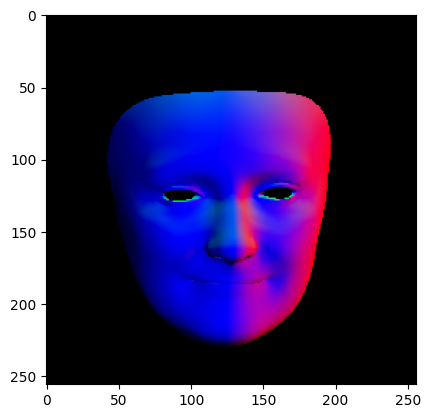

True
(60, 256, 256, 3)


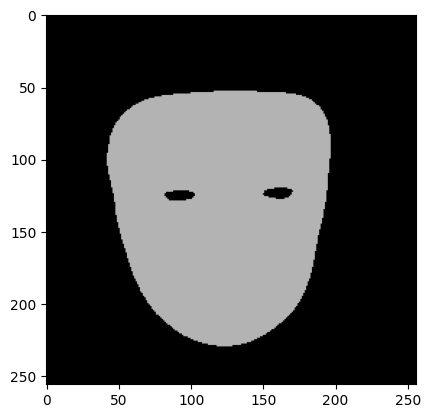

True
(60, 256, 256, 1)


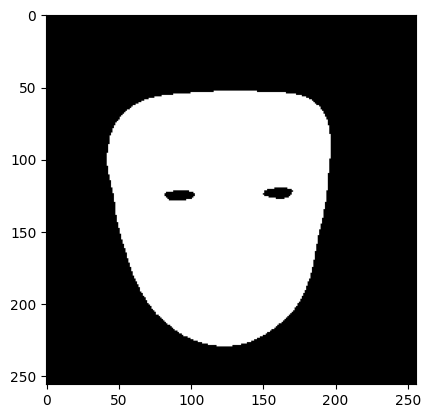

In [29]:
import numpy as np
import matplotlib.pyplot as plt
normals = np.load('./60684_normal.npy').transpose(0, 2, 3, 1)
print(np.all([np.allclose(x, normals[0], rtol=1e-03) for x in normals]))
print(normals.shape)
plt.imshow(normals[0])
plt.show()

albedos = np.load('./60684_albedo.npy').transpose(0, 2, 3, 1)
print(np.all([np.allclose(x, albedos[0], rtol=1e-03) for x in albedos]))
print(albedos.shape)
plt.imshow(albedos[0])
plt.show()

alpha = np.load('./60684_alpha.npy').transpose(0, 2, 3, 1)
print(np.all([np.allclose(x, alpha[0], rtol=1e-03) for x in alpha]))
print(alpha.shape)  
plt.imshow(alpha[0], cmap='gray')
plt.show()
